In [1]:
from keras.layers import *
from keras.models import Model
import numpy as np
from keras import layers
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from keras.constraints import max_norm
#model.add(Dense(64, kernel_constraint=max_norm(2.)))
from keras import optimizers
from keras.regularizers import l2

maxlen = 225

/home/ambitious/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def calculate_logloss(y_true, y_pred):
    s = 0
    for k in np.arange(6):
        s += log_loss(y_true = y_true[:, k], y_pred = y_pred[:, k], eps = 0.0000001)
    return s/6

def calculate_roc_auc_score(y_true, y_pred):
    s = 0
    for k in np.arange(6):
        s += roc_auc_score(y_true = y_true[:, k], y_score = y_pred[:, k])
    return s/6

In [3]:
X = np.load("/home/ambitious/Files/train_X_old.npy")
y = np.load("/home/ambitious/Files/train_y.npy")
matr = np.load("/home/ambitious/Files/fasttext_embed_matrix_old.npy")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
kfold = kf.split(X, y)
res = [a for a in kfold]
tr, te = res[0]
train_X, train_y = X[tr], y[tr]
val_X, val_y = X[te], y[te]

In [4]:
def train_model(model, train_X, train_y, test_X, test_y, gap):
    current_epoch = 1
    best_loss = -1
    val_losses = []
    train_losses = []
    weights = []
    while True:
        train_history = model.fit(train_X, train_y, batch_size = 128, epochs = 1, verbose = True, validation_data = (test_X, test_y))
        loss = train_history.history['val_loss'][-1]
        val_losses.append(loss)
        weights.append(model.get_weights())
        train_losses.append(train_history.history['loss'][-1])
        print("Epoch {0} loss {1} best_loss {2}".format(current_epoch, loss, best_loss))

        current_epoch += 1
        if loss < best_loss or best_loss == -1:
            best_loss = loss
            best_weights = model.get_weights()
            best_epoch = current_epoch
        else:
            print("Patience: {0}".format(current_epoch - best_epoch))
            if current_epoch - best_epoch == gap:
                break
    model.set_weights(best_weights)
    return val_losses, train_losses, weights

In [22]:
def get_DPCNN(matr, n, dense_units = 176):
    input_layer = Input(shape = (200, ))
    x = Embedding(input_dim = matr.shape[0], output_dim = matr.shape[1], weights = [matr], trainable = False)(input_layer)
    x = SpatialDropout1D(0.4)(x)
    y = Convolution1D(filters = 300, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    #y = Dropout(0.1)(y)
    y = Convolution1D(filters = 300, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    #y = Dropout(0.2)(y)
    # y = Flatten()(y)
    z = Add()([x, y])
    x = MaxPooling1D(pool_size = 3, strides = 2)(z)
    for i in np.arange(n):
        y = Convolution1D(filters = 300, kernel_size = 3, activation = 'relu', padding = 'same')(x)
        #y = Dropout(0.1)(y)
        y = Convolution1D(filters = 300, kernel_size = 3, activation = 'relu', padding = 'same')(y)
        #y = Dropout(0.2)(y)
        # y = Flatten()(y)
        z = Add()([x, y])
        x = MaxPooling1D(pool_size = 3, strides = 2)(z)
    x = Flatten()(x)
    #x = Dropout(0.2)(x)
    x = Dense(dense_units, activation = 'relu')(x)
    #x = Dropout(0.2)(x)
    output_layer = Dense(6, activation = 'sigmoid')(x)
    model = Model(input_layer, output_layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    return model

In [6]:
history = []

In [23]:
history.append(train_model(get_DPCNN(matr, 5), train_X, train_y, val_X, val_y, gap = 6))

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 203s 1ms/step - loss: 0.0711 - val_loss: 0.0457
Epoch 1 loss 0.04573461990315583 best_loss -1
Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 201s 1ms/step - loss: 0.0488 - val_loss: 0.0438
Epoch 2 loss 0.04380488758905555 best_loss 0.04573461990315583
Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 201s 1ms/step - loss: 0.0455 - val_loss: 0.0471
Epoch 3 loss 0.04710798980071739 best_loss 0.04380488758905555
Patience: 1
Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 201s 1ms/step - loss: 0.0430 - val_loss: 0.0432
Epoch 4 loss 0.04321794632249405 best_loss 0.04380488758905555
Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 200s 1ms/st

In [24]:
val_loss, train_loss, weights = history[-1]
tmp = get_DPCNN(matr, 5)
preds = []
for w in weights:
    tmp.set_weights(w)
    pred = tmp.predict(val_X, batch_size = 256)
    preds.append((pred, calculate_logloss(y_true = val_y, y_pred = pred)))
preds = [el[0] for el in sorted(preds, key = lambda x: x[1])]
avg_losses = []
for i in np.arange(1, 1 + len(val_loss)):
    avg_losses.append(calculate_logloss(y_pred = np.mean(preds[:i], axis = 0), y_true = val_y))
print("Minimal single log_loss: {0}.".format(np.min(val_loss)))
print("Minimal averaging log_loss : {0}, amount: {1}.".format(np.min(avg_losses), np.argmin(avg_losses)))
l = np.argmin(avg_losses)
avg_scores.append(np.min(avg_losses))
single_scores.append(np.min(val_loss))
print("ROC_AUC: {0}.".format(calculate_roc_auc_score(y_pred = np.mean(preds[:(l + 1)], axis = 0), y_true = val_y)))
epochs = [el[0] for el in sorted([(i, val_loss[i]) 
                                 for i in np.arange(len(val_loss))], key = lambda x: x[1])][:(l + 1)]
preds = []
for epoch in epochs:
    tmp.set_weights(weights[epoch])
    preds.append(tmp.predict(test_X, batch_size = 256, verbose = False))
np.save("dpcnn_dropout_4_0.npy", np.mean(preds, axis = 0))

Minimal single log_loss: 0.03958450873041679.
Minimal averaging log_loss : 0.03869059033562191, amount: 3.
ROC_AUC: 0.9901203866285.


1) дропаут после конволюций 0.1
2) дропаут после коволюций 0.2 - фигня
3) дропаут перед денс слоем - фигня
4) embedding - trainable=true

In [8]:
test_X = np.load("/home/ambitious/Files/test_X_old.npy")

In [9]:
avg_scores = []
single_scores = []

In [11]:
avg_scores = []
single_scores = []

val_loss, train_loss, weights = history[-1]
tmp = get_DPCNN(matr, 5)
preds = []
for w in weights:
    tmp.set_weights(w)
    pred = tmp.predict(val_X, batch_size = 256)
    preds.append((pred, calculate_logloss(y_true = val_y, y_pred = pred)))
preds = [el[0] for el in sorted(preds, key = lambda x: x[1])]
avg_losses = []
for i in np.arange(1, 1 + len(val_loss)):
    avg_losses.append(calculate_logloss(y_pred = np.mean(preds[:i], axis = 0), y_true = val_y))
print("Minimal single log_loss: {0}.".format(np.min(val_loss)))
print("Minimal averaging log_loss : {0}, amount: {1}.".format(np.min(avg_losses), np.argmin(avg_losses)))
l = np.argmin(avg_losses)
avg_scores.append(np.min(avg_losses))
single_scores.append(np.min(val_loss))
print("ROC_AUC: {0}.".format(calculate_roc_auc_score(y_pred = np.mean(preds[:(l + 1)], axis = 0), y_true = val_y)))
epochs = [el[0] for el in sorted([(i, val_loss[i]) 
                                 for i in np.arange(len(val_loss))], key = lambda x: x[1])][:(l + 1)]
preds = []
for epoch in epochs:
    tmp.set_weights(weights[epoch])
    preds.append(tmp.predict(test_X, batch_size = 256, verbose = False))
np.save("dpcnn_dropout_4_1.npy", np.mean(preds, axis = 0))

Minimal single log_loss: 0.03972455625927587.
Minimal averaging log_loss : 0.03845248497565846, amount: 2.
ROC_AUC: 0.9894340923998497.


In [17]:
tmp = avg_scores[:3] + avg_scores[4:]

In [19]:
avg_scores = tmp

In [20]:
single_scores = single_scores[:3] + single_scores[4:]

In [13]:
import matplotlib, seaborn
import matplotlib.pyplot as plt
#matplotlib.rc('xtick', labelsize=10) 
#matplotlib.rc('ytick', labelsize=10) 
seaborn.set_style('darkgrid')
%pylab inline
matplotlib.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


/home/ambitious/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multiply', 'concatenate', 'dot', 'copy', 'minimum', 'average', 'subtract', 'maximum', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
matplotlib.rcParams.update({'font.size': 15})

Text(0,0.5,'Log Loss')

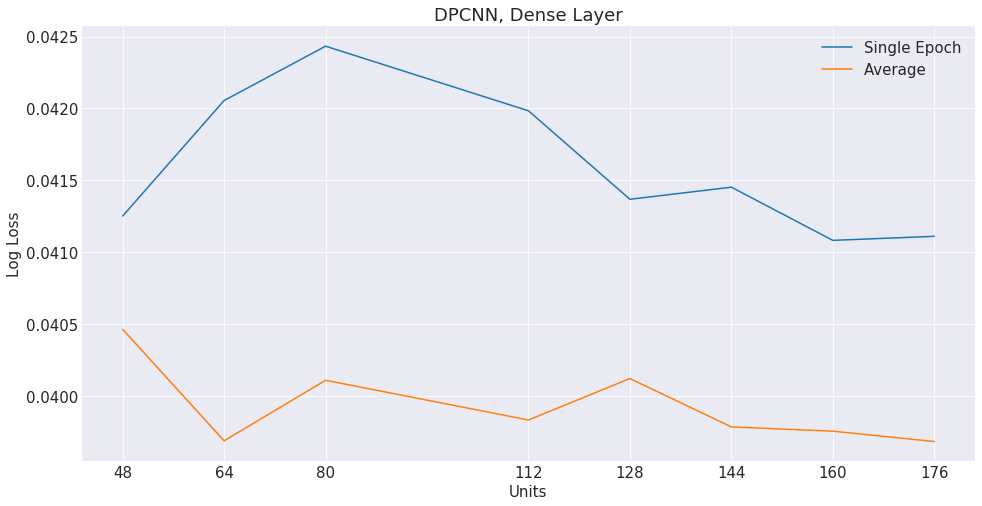

In [25]:
plt.figure(figsize = (16, 8))
plt.plot([48, 64, 80, 112, 128, 144, 160, 176], single_scores)
plt.plot([48, 64, 80, 112, 128, 144, 160, 176], avg_scores)
plt.title("DPCNN, Dense Layer")
plt.legend(["Single Epoch", "Average"])
plt.xlabel("Units")
plt.xticks([48, 64, 80, 112, 128, 144, 160, 176])
plt.ylabel("Log Loss")